In [1]:
# K-Means++ Clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random
import sys
from sklearn import preprocessing
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap

In [2]:
dataset = pd.read_csv('listings.csv')

# Replace the empty string with np.nan
dataset.replace(r'', np.nan)

# Ignore listings that contain missing values
nan_removed = dataset[~pd.isnull(dataset).any(axis=1)]

# Extract columns - latitude, longitude, price
data = nan_removed[['latitude','longitude','price']]

# Scale the data
data_scaled = preprocessing.scale(data)

# data_scaled = data_scaled[:15000]

In [3]:
# Initialization Phase
def distance(a, b):
    """
    Returns the Euclidean distance between a, b
    """
    return sum([(a - b) ** 2 for a, b in zip(a, b)]) ** 0.5

def distance_squared(a, b):
    """
    Returns the squared distance between a, b
    """
    return distance(a, b) ** 2

def generate_k_pp(dataset, k):
    """
    Given `data_set`, which is an array of arrays,
    return a random set of k points from the data_set
    """
    center = random.choice(dataset)
    k_points = [center]

    while len(k_points) < k:
        prob = []
        for point in dataset:
            prob.append(distance_squared(center, point))
        
        prob = [p/sum(prob) for p in prob]
        center = random.choices(dataset, prob)[0]

        k_points.append(center)

    return k_points

In [4]:
# Main functions used in Iteration Phase
def point_avg(points):
    """
    Accepts a list of points, each with the same number of dimensions.   
    Returns a new point which is the center of all the points.
    """
    n = len(points)
    if n != 0:
        x = sum([p[0] for p in points]) / n
        y = sum([p[1] for p in points]) / n
        z = sum([p[2] for p in points]) / n
    return [x, y, z]

def update_centers(dataset, assignments):
    """
    Accepts a dataset and a list of assignments.
    Computes the center for each of the assigned groups.
    Returns `k` centers in a list.
    """
    k = max(assignments) + 1
    clusters = [[] for i in range(k)]
    for pointIndex, pointAssignment in enumerate(assignments):
        clusters[pointAssignment].append(dataset[pointIndex])

    new_centers = []
    for cluster in clusters:
        new_centers.append(point_avg(cluster))

    return new_centers

def assign_points(data_points, centers):
    """
    Accepts a list of data_points and centers.
    Returns the names of the clusters that each data point belongs to
    """
    assignments = []
    for point in data_points:
        shortest = sys.maxsize  # positive infinity
        shortest_index = 0
        for i in range(len(centers)):
            val = distance(point, centers[i])
            if val < shortest:
                shortest = val
                shortest_index = i
        assignments.append(shortest_index)
    return assignments

In [5]:
# Iteration Phase
def lloyds_algo(dataset, k_points):
    """
    Accepts a dataset and initial k points as centers.
    Repeat the algorithm until convergence.
    Returns the final clusters.
    """
    assignments = assign_points(dataset, k_points)
    old_assignments = None
    while assignments != old_assignments:
        new_centers = update_centers(dataset, assignments)
        old_assignments = assignments
        assignments = assign_points(dataset, new_centers)
    clustering = defaultdict(list)
    for assignment, point in zip(assignments, dataset):
        clustering[assignment].append(point)
    return clustering

def k_means_pp(dataset, k):
    """
    Runs k-means++ clustering algorithm
    """
    if k not in range(1, len(dataset)+1):
        raise ValueError("lengths must be in [1, len(dataset)]")

    k_points = generate_k_pp(dataset, k)
    return lloyds_algo(dataset, k_points)

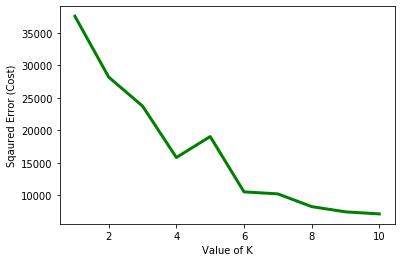

In [ ]:
# Determine the optimal value of K
def cost_function(clustering):
    """
    Calculates the squared error for the clustered points
    """
    cost = 0
    for idx in clustering:
        center = point_avg(clustering[idx])
        cost += sum([distance_squared(center, p) for p in clustering[idx]])

    return cost


cost =[] 
for i in range(1, 11): 
    clustering = k_means_pp(data_scaled, i) # run the implemented k_means++ algorithm
    cost.append(cost_function(clustering))
    
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

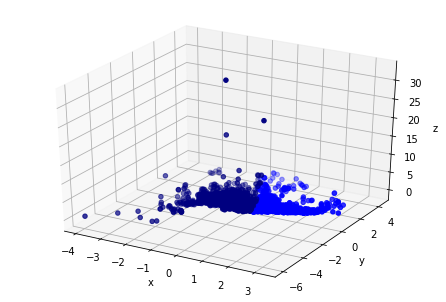

In [6]:
# final clustering
clustering = k_means_pp(data_scaled, 4)

# 3D Visualization of K-means Clustering
jet=plt.get_cmap('jet')
colors=iter(jet(np.linspace(0,1,10)))

fig=plt.figure()
ax=Axes3D(fig)
for idx in clustering:
    x = np.array(clustering[idx])[:,0]
    y = np.array(clustering[idx])[:,1]
    z = np.array(clustering[idx])[:,2]
    ax.scatter(x, y, z, color=next(colors))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()